In [1]:
!pip install opencv-python

In [2]:
!pip install pillow

In [11]:
import numpy as np
import cv2
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [12]:
EPISODES = 30000
SHOW_EVERY = 3000

epsilon = 0.6
EPS_DECAY = 0.9998
DISCOUNT = 0.95
LEARNING_RATE = 0.1

In [13]:
class Cube:
    def __init__(self,size):
        self.size = size
        self.x = np.random.randint(0, self.size)
        self.y = np.random.randint(0, self.size)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self,other):
        return (self.x-other.x,self.y-other.y)
    
    def __eq__(self,other):
        return self.x == other.x and self.y == other.y
    
    def action(self,choise):
        if choise == 0 :
            self.move(x=1, y=1)
        elif choise == 1 :
            self.move(x=-1, y=1)
        elif choise == 2 :
            self.move(x=1, y=-1)
        elif choise == 3 :
            self.move(x=-1, y=-1)
        elif choise == 4 :
            self.move(x=0, y=1)        
        elif choise == 5 :
            self.move(x=0, y=-1) 
        elif choise == 6 :
            self.move(x=1, y=0) 
        elif choise == 7 :
            self.move(x=-1, y=0)             
        elif choise == 8 :
            self.move(x=0, y=0)             
            
    def move(self,x=False,y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y   
            
        if self.x < 0 :
            self.x = 0
        elif self.x >= self.size :
            self.x = self.size -1

        if self.y < 0 :
            self.y = 0
        elif self.y >= self.size :
            self.y = self.size -1

In [14]:
class envCube:
    SIZE = 10
    OBSERVATION_SPACE_VALUES = (SIZE,SIZE,3)
    ACTION_SPACE_VALUES = 9
    RETURN_IMAGE = False
    
    FOOD_REWARD = 25
    ENEMY_PENALITY = -300
    MOVE_PENALITY = -1    
    
    d = {1:(255,0,0), #blue
         2:(0,255,0), #green
         3:(0,0,255)} #red

    PLAYER_N = 1
    FOOD_N =2
    ENEMY_N =3    
    
    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        while self.food == self.player:
            self.food = Cube(self.SIZE)
        
        self.enemy = Cube(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Cube(self.SIZE)
        
        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food)+(self.player - self.enemy) 
        
        self.episode_step = 0
        
        return observation
    
    def step(self,action):
        self.episode_step += 1
        self.player.action(action)
        self.food.move()
        self.enemy.move()

        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food)+(self.player - self.enemy)

        if self.player == self.food :
            reward = self.FOOD_REWARD
        elif self.player == self.enemy :
            reward = self.ENEMY_PENALITY
        else:
            reward = self.MOVE_PENALITY

        done = False
        if self.player == self.food or self.player == self.enemy or self.episode_step>=200:
            done = True
        
        return new_observation,reward,done
    
    def render(self):
        img = self.get_image()       
        img = img.resize((800,800))
        cv2.imshow('Predator',np.array(img))
        cv2.waitKey(1)
    
    def get_image(self):
        env = np.zeros((self.SIZE,self.SIZE,3), dtype=np.uint8)
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]
        img = Image.fromarray(env,'RGB')
        return img

    def get_qtable(self,qtable_name=None):
        if qtable_name is None:
            q_table = {}
            for x1 in range(-self.SIZE+1, self.SIZE):
                for y1 in range(-self.SIZE+1, self.SIZE):
                    for x2 in range(-self.SIZE+1, self.SIZE):
                        for y2 in range(-self.SIZE+1, self.SIZE):
                            q_table[(x1,y1,x2,y2)] = [np.random.uniform(-5,0) for i in range(self.ACTION_SPACE_VALUES)]
        else:
            with open(qtable_name,'rb') as f:
                q_table=pickle.load(f)
        return q_table

episode #0, epsilon:0.6
mean reward:nan


/Users/liangsy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/liangsy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode #3000, epsilon:0.32926722239570905
mean reward:-177.114
episode #6000, epsilon:0.18069483957364205
mean reward:-137.52466666666666
episode #9000, epsilon:0.09916147987941909
mean reward:-99.12666666666667
episode #12000, epsilon:0.054417708414240505
mean reward:-76.72733333333333
episode #15000, epsilon:0.029863279497827713
mean reward:-62.33233333333333
episode #18000, epsilon:0.016388331819794114
mean reward:-53.786
episode #21000, epsilon:0.00899356749667138
mean reward:-45.93933333333333
episode #24000, epsilon:0.00493547831509555
mean reward:-42.602333333333334
episode #27000, epsilon:0.0027084853933429503
mean reward:-35.649
27001


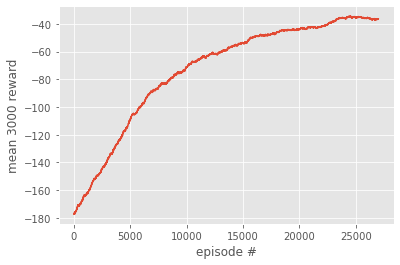

In [15]:
env = envCube()
q_table = env.get_qtable()

episode_rewards = []
for episode in range(EPISODES):
    obs = env.reset()
    done = False
    
    if episode%SHOW_EVERY == 0 :
        print(f'episode #{episode}, epsilon:{epsilon}')
        print(f'mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}')
        show = True
    else:
        show = False
    
    episode_reward = 0
    while not done:
        
        if np.random.random() > epsilon :
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,env.ACTION_SPACE_VALUES)
        
        new_obs,reward,done =  env.step(action)
        
        #Update the Q_table
        current_q = q_table[obs][action]
        max_future_q = np.max(q_table[new_obs])                
        if reward == env.FOOD_REWARD:
            new_q = env.FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward+DISCOUNT*max_future_q)        
        q_table[obs][action] = new_q
        obs = new_obs
        
        if show:
            env.render()
                   
        episode_reward += reward

    
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards,np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)

In [10]:
env = envCube()
print(env.reset())
new_observation,reward,done = env.step(3)
print(new_observation)
print(reward)
print(done)
env.render()
q_table1 = env.get_qtable()
q_table1[new_observation]

(-2, -8, -8, -5)
(-1, -9, -7, -5)
-1
False


[-2.1932051595425923,
 -4.688459827321189,
 -4.667169373304091,
 -2.6067662017395,
 -4.14886543538474,
 -3.0245484307537507,
 -3.0331143214077096,
 -3.5303108268635826,
 -1.1933610124636345]

In [56]:
with open(f'qtable_{int(time.time())}.pickle','wb') as f:
    pickle.dump(q_table,f)

27001


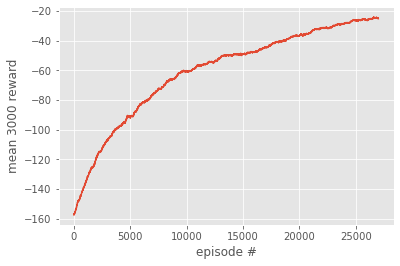

In [55]:
moving_avg = np.convolve(episode_rewards,np.ones((SHOW_EVERY,))/SHOW_EVERY,mode='valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))],moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

In [50]:
conv = np.convolve([3,8,10,9,11,23,44,55,57,48],np.ones((3,))/3,mode='valid')
print(conv)

[ 7.          9.         10.         14.33333333 26.         40.66666667
 52.         53.33333333]


In [53]:
np.mean([10,9,11])

10.0

In [6]:
food = Cube()
player = Cube()
enemy = Cube()

env = np.zeros((SIZE,SIZE,3), dtype=np.uint8)
# env[food.x][food.y] = d[FOOD_N]
env[player.x][player.y] = d[PLAYER_N]
# env[enemy.x][enemy.y] = d[ENEMY_N]

img = Image.fromarray(env,'RGB')
img = img.resize((800,800))

cv2.imshow('',np.array(img))

if cv2.waitKey(500) & 0xFF == ord('q') :
    pass


In [6]:
print(len(q_table))

130321


In [8]:
19**4

130321

In [9]:
print(q_table[((1,3),(-2,-4))])

[-2.7773554618819225, -3.563705005054187, -2.2330000919778783, -2.4506302861658162]


In [26]:
player = Cube()
print(player)
player.action(0)
print(player)

7,4
8,5


In [3]:
d[FOOD_N]

(0, 255, 0)